In [710]:
import pandas as pd
import json
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (25, 13)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
%matplotlib inline

In [711]:
full = pd.read_table('../results.tsv')

In [712]:
display = [
    'result.running_time', 'result.test_acc', 'model.type',
    'model.cell_type', 'model.max_len',
    'feat.N', 'feat.last_char', 'feat.include_smaller_ngrams',
    'data.X_shape', 'feat.type', 'feat.use_padding',
    'model.batch_size', 'model.nb_epoch', 'model.optimizer', 'model.optimizer_kwargs', 'model.layers', 
    'model.cell_num', 'model.early_stopping',
    
]

# Basic statistics

Number of experiments:

In [713]:
len(full)

2139

Number of experiments per experiment type:

In [714]:
full.groupby('global.exp_type').size().to_frame()

,0
global.exp_type,
accusative,55
conditional,61
noun_cases10,48
noun_verb,1729
plural,60
pos4,69
tense,62
verb_person,55


Number of experiments-per-type and network:

In [715]:
full.groupby(['global.exp_type', 'model.type']).size().unstack('model.type')

model.type,cnn,ffnn,rnn
global.exp_type,,,
accusative,28,15,12
conditional,14,30,17
noun_cases10,14,17,17
noun_verb,107,851,771
plural,20,18,22
pos4,22,20,27
tense,19,24,19
verb_person,19,14,22


Maximum accuracy:

model.type,cnn,ffnn,rnn
global.exp_type,,,
accusative,0.952000,0.984500,0.987500
conditional,0.963000,0.999500,0.999500
noun_cases10,0.920190,0.999830,0.999970
noun_verb,0.882000,0.971250,0.970500
plural,0.935000,0.973778,0.968778
pos4,0.869375,0.930438,0.927125
tense,0.934500,0.966000,0.971250
verb_person,0.896778,0.989000,0.994111


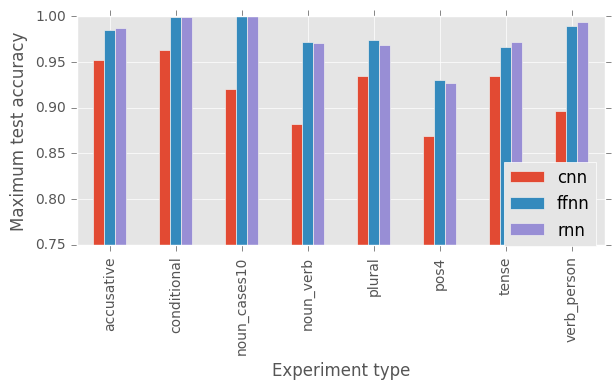

In [716]:
d = full.groupby(['global.exp_type', 'model.type']).max()['result.test_acc'].unstack('model.type')
fig = plt.figure()
d.plot(kind='bar', ylim=(.75, 1))
plt.legend(bbox_to_anchor=[1, 0.4])
plt.tight_layout()
plt.xlabel('Experiment type')
plt.ylabel('Maximum test accuracy')
plt.savefig('exptype.png'.format(typ), dpi=900)
d

# NOUN vs. VERB

In [717]:
nv = full[full['global.exp_type'] == 'noun_verb']
len(nv)

1729

## Absolute best configuration

In [718]:
best = nv.loc[nv['result.test_acc'].idxmax()].to_frame()
print(best.loc['result.test_acc'])
best.loc[display].dropna()

996    0.97125
Name: result.test_acc, dtype: object


,996
result.running_time,51.3249
result.test_acc,0.97125
model.type,ffnn
feat.N,3
feat.last_char,8
feat.include_smaller_ngrams,0
data.X_shape,"(60000, 17078)"
feat.type,ngram
feat.use_padding,1
model.batch_size,512


## Highest accuracy per network type

In [719]:
nv.groupby('model.type').max()['result.test_acc'].to_frame()

,result.test_acc
model.type,
cnn,0.88200
ffnn,0.97125
rnn,0.97050


## Best RNN

In [720]:
d = nv[nv['model.type'] == 'rnn']
best = d.loc[d['result.test_acc'].idxmax()].to_frame()
print(best.loc['result.test_acc'])
best.loc[display].dropna()

171    0.9705
Name: result.test_acc, dtype: object


,171
result.running_time,139.597
result.test_acc,0.9705
model.type,rnn
model.cell_type,LSTM
model.max_len,8
data.X_shape,"(60000, 8, 39)"
feat.type,character_sequence
model.batch_size,64
model.nb_epoch,300
model.optimizer,rmsprop


## Best CNN

In [721]:
d = nv[nv['model.type'] == 'cnn']
best = d.loc[d['result.test_acc'].idxmax()].to_frame()
print(best.loc['result.test_acc'])
best.loc[display].dropna()

1317    0.882
Name: result.test_acc, dtype: object


,1317
result.running_time,6.46794
result.test_acc,0.882
model.type,cnn
model.max_len,7
data.X_shape,"(60000, 7, 39)"
feat.type,character_sequence
model.batch_size,512
model.nb_epoch,300
model.optimizer,rmsprop
model.optimizer_kwargs,{'lr': 0.01}


## Loss and accuracy during training

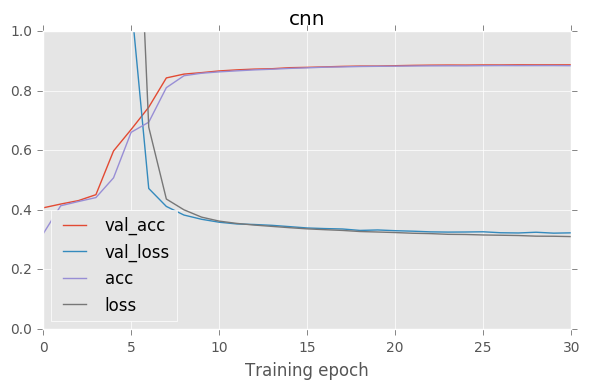

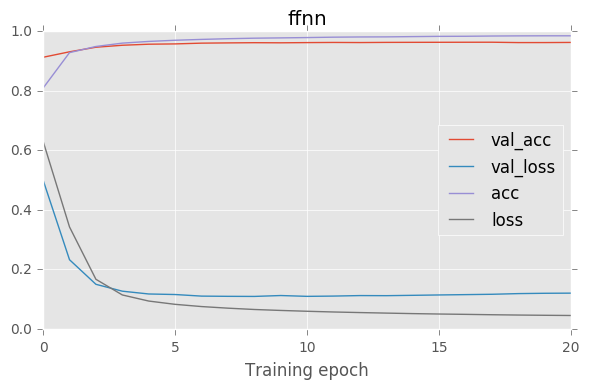

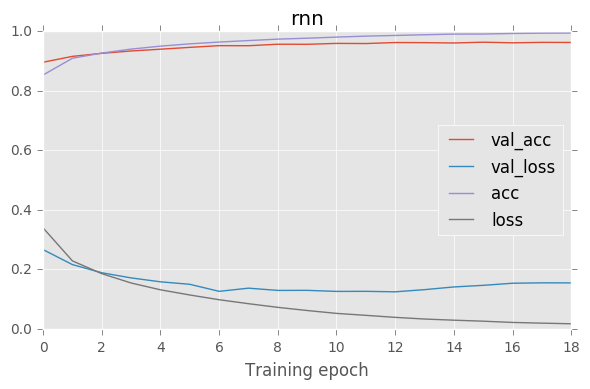

In [722]:
for row in nv.loc[nv.groupby('model.type').idxmax()['result.test_acc']].iterrows():
    typ = row[1]['model.type']
    history = eval(row[1]['result.history_history'])
    epoch = eval(row[1]['result.history_epoch'])
    df = pd.DataFrame(history, index=epoch)
    fig = plt.figure()
    df.plot(y=['val_acc', 'val_loss', 'acc', 'loss'], title=typ, ylim=(0, 1))
    plt.xlabel("Training epoch")
    plt.tight_layout()
    plt.savefig('{}.png'.format(typ), dpi=900)


# RNN cell types and the number of cells

19


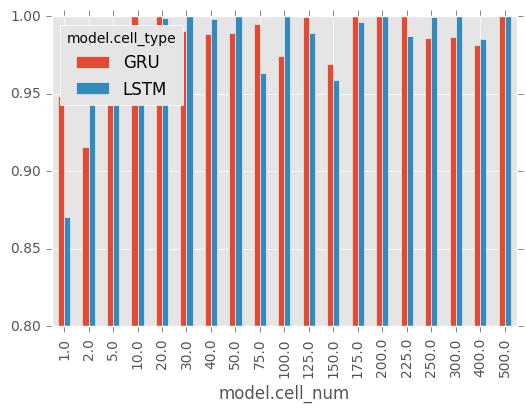

In [723]:
f = full[full['model.type'] == 'rnn'].copy()
f['model.cell_num_log'] = f['model.cell_num'].apply(lambda x: int(np.log2(x)))
combinations = f.pivot_table(values='result.test_acc', columns='model.cell_type', aggfunc=np.max, index=['model.cell_num'])
print(len(combinations))
combinations.plot(kind='bar', ylim=(.8, 1))

# Other experiments

In [724]:
other = full[full['global.exp_type'] != 'noun_verb']
len(other)

410

Maximum test accuracy per experiment type

In [725]:
other.groupby(['global.exp_type', 'model.type']).max()['result.test_acc'].unstack('model.type')

model.type,cnn,ffnn,rnn
global.exp_type,,,
accusative,0.952000,0.984500,0.987500
conditional,0.963000,0.999500,0.999500
noun_cases10,0.920190,0.999830,0.999970
plural,0.935000,0.973778,0.968778
pos4,0.869375,0.930438,0.927125
tense,0.934500,0.966000,0.971250
verb_person,0.896778,0.989000,0.994111


Plot training history

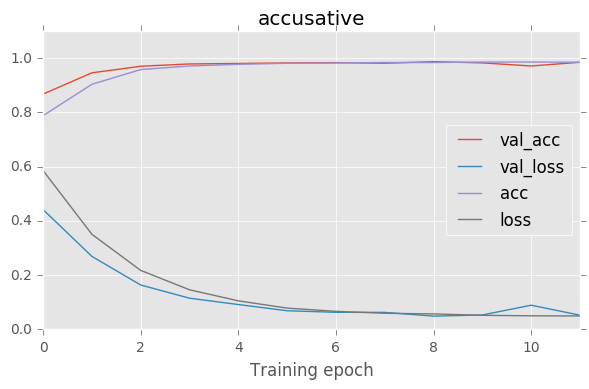

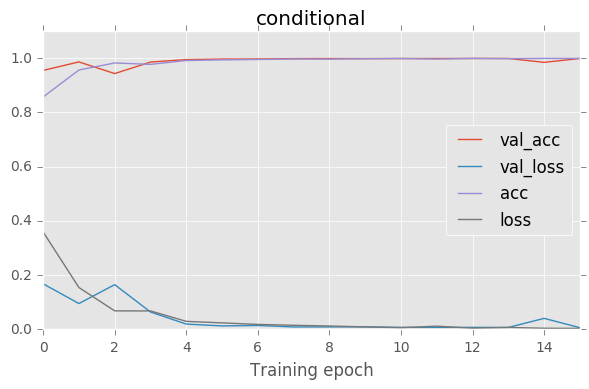

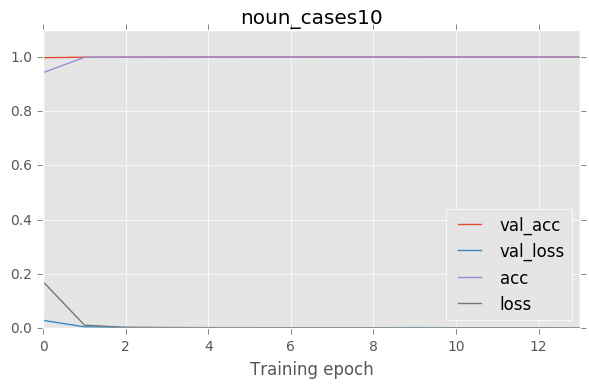

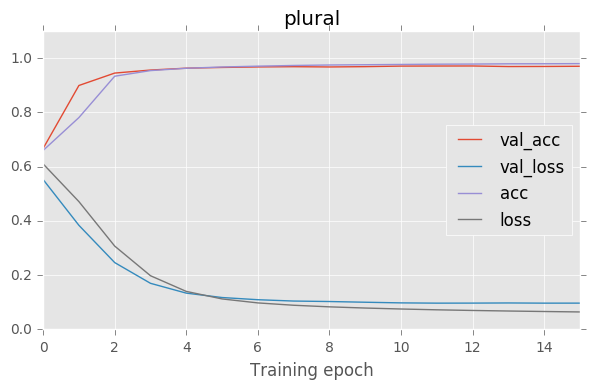

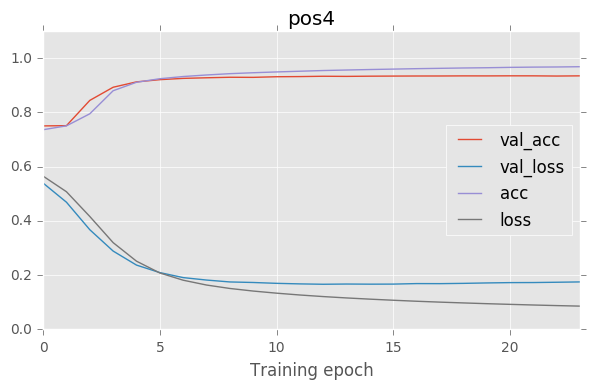

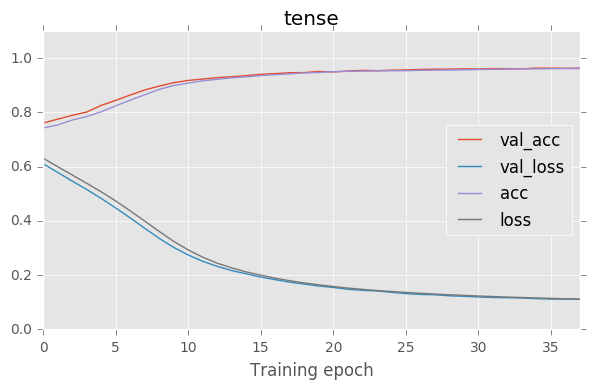

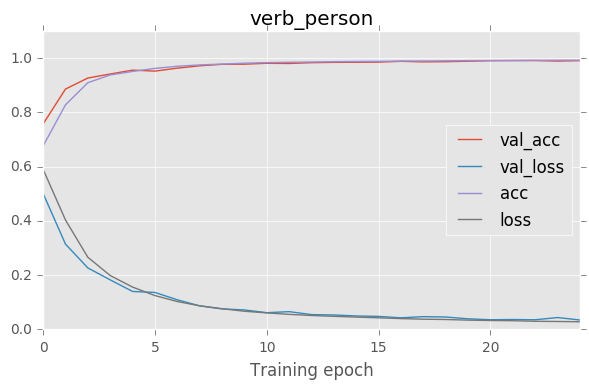

In [726]:
for row in other.loc[other.groupby('global.exp_type').idxmax()['result.test_acc']].iterrows():
    typ = row[1]['global.exp_type']
    history = eval(row[1]['result.history_history'])
    epoch = eval(row[1]['result.history_epoch'])
    df = pd.DataFrame(history, index=epoch)
    fig = plt.figure()
    df.plot(y=['val_acc', 'val_loss', 'acc', 'loss'], title=typ, ylim=(0, 1.1))
    plt.xlabel("Training epoch")
    plt.tight_layout()